### WaveNet

---

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8  # Context length: How many characters do we take to predict the next one.

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -------------------------------

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters (Trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers (Trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Calculate forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True) # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -------------------------------

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# -------------------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape # Batch, Block Size, Embedding Context
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -------------------------------

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [8]:
torch.manual_seed(42)

In [26]:
n_embd = 10         # The dimensionality of the character embedding vectors
n_hidden = 68      # The number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Last layer: make softmax less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [25]:
# Sample batch of 4 examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape) # examples by block_size
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 14,  9,  3, 11],
        [ 0,  0,  0,  0,  0, 12, 25, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  2, 12,  1]])

In [24]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [14]:
epochs = 200000
batch_size = 32
lossi = []

# Training loop
for i in range(epochs):

    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) #Loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update: Simple SGD
    lr = 0.1 if i < 150000 else 0.01 # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Metrics
    if i % 10000 == 0:
        print(f'{i:7d} / {epochs:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.285689
  10000 /  200000: 1.983691
  20000 /  200000: 2.285401
  30000 /  200000: 2.509554
  40000 /  200000: 2.149917
  50000 /  200000: 1.966253
  60000 /  200000: 1.708086
  70000 /  200000: 1.908896
  80000 /  200000: 2.342445
  90000 /  200000: 2.246199
 100000 /  200000: 1.815844
 110000 /  200000: 1.946698
 120000 /  200000: 1.827368
 130000 /  200000: 1.976069
 140000 /  200000: 1.733927
 150000 /  200000: 2.135737
 160000 /  200000: 2.253592
 170000 /  200000: 1.810671
 180000 /  200000: 2.123183
 190000 /  200000: 2.532130


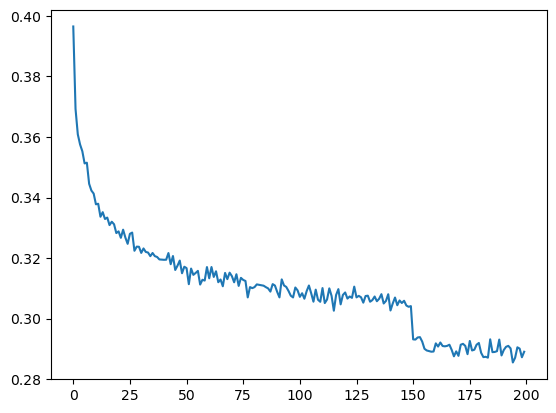

In [15]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # Average lossi by factor epochs by 1000

In [16]:
# Set layers to eval mode (needed for batchNorm especially)
for layer in model.layers:
    layer.training = False

In [17]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9177604913711548
val 2.03363037109375


In [18]:
# Sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # Shift the context window to track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the special '.' token, break
        if ix == 0:
            break
      
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

lyze.
gwosen.
macayl.
zikky.
leelani.
taion.
dayah.
ahros.
johnreigh.
sebay.
graycelyne.
ellagan.
miliasa.
hamby.
dence.
suhaya.
kayali.
covronno.
gitia.
kamel.
